# Consensus Income Classification Data Analysis

## Introduction

In the workforce, many factors can influence an individual’s salary. These can include (but are not limited to): level of education, occupation, age, sex, and race. Data from the U.S. Bureau of Labor Statistics found that men working in management earned more than their female counterparts, while people working in the service industry generally made the smallest salaries. In our project, we will design a classification model that will predict if an individual will make more than or less than $50,000, based on specific predictors. 

Would an 18 year old high school graduate working 40 hours per week have made more or less than $50,000 annually in 1994?

This dataset came from the UCI Machine Learning Repository and summarizes U.S. census data from 1994. It contains variables identifying age, work class, education, marital status, occupation, relationship, race, sex, capital gain and loss, hours per week, and native country. The variables influence whether an individual makes less than or more than \\$50,000. We will select specific variables to predict an individual’s categorical salary (less than or greater than \\$50,000).

In [2]:
library(tidyverse)
library(dplyr)
library(repr)
library(tidymodels)
library(ggplot2)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6) #displays maximum of 6 rows of dataframe

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [7]:
options(repr.plot.width = 8, repr.plot.height = 7)
set.seed(2022)
consensus_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", col_names = FALSE)
colnames(consensus_data) <- c("age", "workclass","fnlwgt","education","education_num","marital_status","occupation","relationship","race","sex","capital_gain","capital_loss","hours_per_week","native_country","income")
consensus_data <- mutate(consensus_data, income = as_factor(income))

#consensus_data
consensus_subset <- consensus_data |>
                     select(age, education_num, hours_per_week, income)
consensus_subset


Rows: 32561 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X2, X4, X6, X7, X8, X9, X10, X14, X15
dbl (6): X1, X3, X5, X11, X12, X13

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<fct>
39,13,40,<=50K
50,13,13,<=50K
38,9,40,<=50K
⋮,⋮,⋮,⋮
58,9,40,<=50K
22,9,20,<=50K
52,9,40,>50K


In [8]:
#Splitting data into 75% training and 25% testing sets
consensus_split <- initial_split(consensus_subset, prop = 3/4, strata = income)
consensus_training <- training(consensus_split) 
consensus_testing <- testing(consensus_split)
#consensus_training

In [9]:
# Summarizing number of observations per classification category
counts <- group_by(consensus_training, income) |>
          summarize(n = n())
counts

income,n
<fct>,<int>
<=50K,18540
>50K,5880


In [10]:
#Means of the predictor variables that will be used within the analysis
predictor_averages <- consensus_training |>
                      select(-income)|>
                      summarize(across(age:hours_per_week, mean, na.rm = TRUE))
predictor_averages

age,education_num,hours_per_week
<dbl>,<dbl>,<dbl>
38.57719,10.07707,40.44496


## Methods

In [11]:
#Scaling predictors
income_recipe <- recipe(income ~ ., data = consensus_training) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors()) |>
            #step_upsample(income, over_ratio =1, skip = FALSE) |>
            prep()
income_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Training data contained 24420 data points and no missing data.

Operations:

Scaling for age, education_num, hours_per_week [trained]
Centering for age, education_num, hours_per_week [trained]

In [14]:
scaled_income <- bake(income_recipe, consensus_subset)
scaled_income

age,education_num,hours_per_week,income
<dbl>,<dbl>,<dbl>,<fct>
0.03092662,1.1368347,-0.03616749,<=50K
0.83552802,1.1368347,-2.23078144,<=50K
-0.04221896,-0.4189109,-0.03616749,<=50K
⋮,⋮,⋮,⋮
1.4206927,-0.4189109,-0.03616749,<=50K
-1.2125483,-0.4189109,-1.66180745,<=50K
0.9818192,-0.4189109,-0.03616749,>50K


We created a model specifiction 

In [15]:
#Selecting K
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [16]:
#5 fold cross-validation
income_vfold <- vfold_cv(consensus_training, v = 5, strata = income)

In [17]:
#Making Workflow
knn_results <- workflow() |>
       add_recipe(income_recipe) |>
       add_model(knn_tune) |>
       tune_grid(resamples = income_vfold, grid = 20) |>
       collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7589271,5,0.0010492324,Preprocessor1_Model01
1,roc_auc,binary,0.5703025,5,0.0024824651,Preprocessor1_Model01
2,accuracy,binary,0.7575348,5,0.0007163332,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.7301682,5,0.002938073,Preprocessor1_Model14
15,accuracy,binary,0.7894349,5,0.001610383,Preprocessor1_Model15
15,roc_auc,binary,0.7325981,5,0.002693392,Preprocessor1_Model15


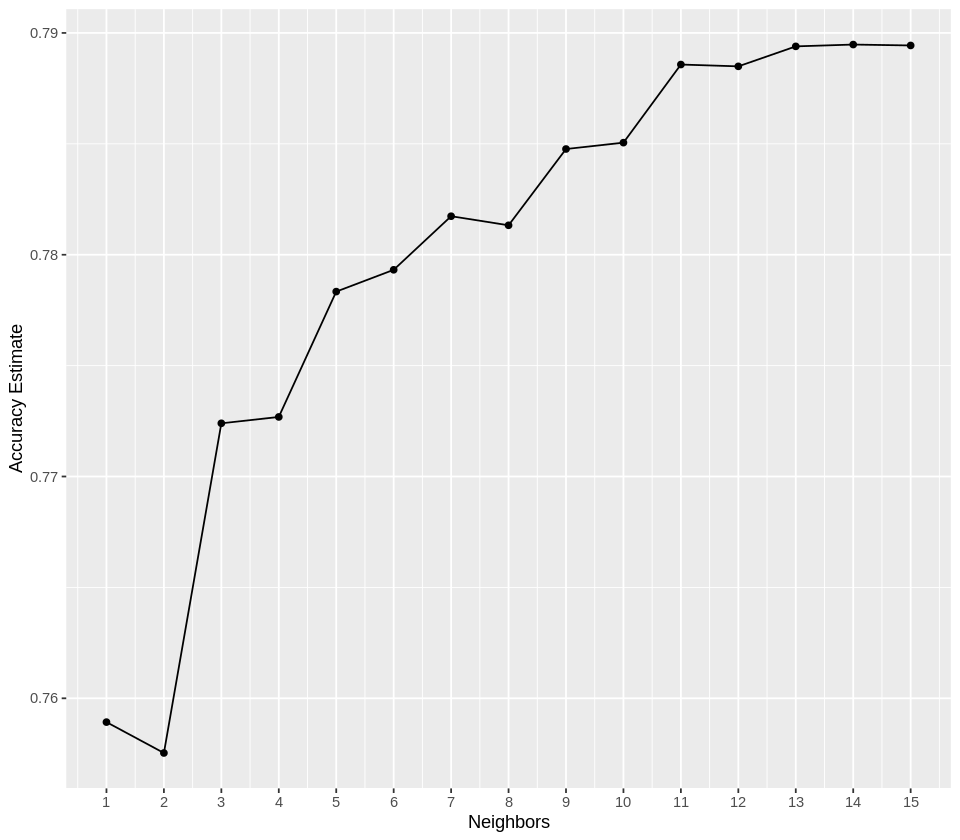

In [20]:
accuracies <- knn_results |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 15, by = 1))  # adjusting the x-axis
       #scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis
accuracy_versus_k